In [1]:
!pip install pygifsicle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pygifsicle: filename=pygifsicle-1.0.7-py3-none-any.whl size=4094 sha256=9fcf837df00b786bfb9d07054898f84bcad1c82a8ec005176e12d93c3834010e
  Stored in directory: /root/.cache/pip/wheels/10/1a/64/20bef5aa8a98420f584a2f5befeccce58aceefcab0063ee429
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=51150989d9fd073ab732c4f9ca9d0215bf9638094ff2796c19a4ad94f7cffc5e
  Stored in directory: /root/.cache/pip/wheels/b6/72/c8/3054a5897ba0713dfa7a941364d68cbd42b0755c8e2ec1c18c
Successfully built pygifsicle support_developer


In [2]:
!pip install colabturtle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for colabturtle: filename=ColabTurtle-2.1.0-py3-none-any.whl size=7642 sha256=90ef89dbec7f063bc80d08d1eb4dbf2eaebc3fef445fdb2f89098ec50166ce1c
  Stored in directory: /root/.cache/pip/wheels/5b/86/e8/54f5c8c853606e3a3060bb2e60363cbed632374a12e0f33ffc
Successfully built colabturtle


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import statistics
import math
import itertools
import turtle
import re
import imageio
import imageio
import os
import pygifsicle
from ColabTurtle import *

In [4]:
#FF[-F-F][+F+F]

def CantidadMasMenos(cadena):
  contador = 0
  for caracter in cadena:
      if caracter == "+":
          contador += 1
      elif caracter == "-":
          contador -= 1
  return contador == 0


def contarCorchetes(gen):
  contador = 0
  paresEncontrados = 0
  for caracter in gen:
      if caracter == "[":
          contador += 1
      elif caracter == "]":
          contador -= 1
          if contador < 0:
              contador = 0
          elif contador == 0:
              paresEncontrados += 1
  return paresEncontrados

def fitness(gen):
  contador = 0
  aux = gen
  aux = ''.join(aux) 
  mas = len(re.compile("\+F").findall(aux))
  menos = len(re.compile("-F").findall(aux))
  if menos != 0:
    contador += menos*5
  if mas != 0:
    contador += mas*5
  if aux[:2]=='FF':
    contador+=20
  if contarCorchetes(aux) == 2:
    contador += 15
  if CantidadMasMenos(aux):
    contador += 0
  return contador

def verificardorIndividuo(s):
    pila = []
    for caracter in s:
        if caracter == '[':
            pila.append('[')
        elif caracter == ']':
            if len(pila) == 0 or pila[-1] != '[':
                return False
            pila.pop()
    return len(pila) == 0

axiom = 'F'
genPer = 'F[+F[+F]-F][-F]F'
rules = {'F' : 'F[+F[+F]-F][-F]F'} 
flit = ['F','+','-','[',']']

In [5]:
class Poblacion:
  def __init__(self, numPoblacion, tamIndividuo, pbb, nGen):
    self.poblacion = None
    self.numPoblacion = numPoblacion
    self.tamIndividuo = tamIndividuo
    self.pbb = pbb
    self.fitness = np.array([])
    self.seleccion = Seleccion()
    self.cruce = Cruce()
    self.mutacion = Mutacion()
    self.visualizacion = Visualizacion(nGen)


  def crear(self):
    CreaPoblacion = np.random.choice(['F','+','-','[',']'], size=(self.numPoblacion, self.tamIndividuo), p=[self.pbb,self.pbb,self.pbb,self.pbb,self.pbb])
    for i in range(len(CreaPoblacion)):
       if not verificardorIndividuo(CreaPoblacion[i]):
          while not verificardorIndividuo(CreaPoblacion[i]):
             CreaPoblacion[i] = np.random.choice(['F','+','-','[',']'], size=(1, self.tamIndividuo), p=[self.pbb,self.pbb,self.pbb,self.pbb,self.pbb])[0]
    for i in range(len(CreaPoblacion)):
      self.fitness = np.append(self.fitness, fitness(CreaPoblacion[i]))
    self.poblacion = np.column_stack((CreaPoblacion, self.fitness))

In [6]:
class Seleccion:

  def seleccionRuleta(self, poblacion, fitness):
    totalFitness = np.sum(fitness)
    probabilidadSeleccion = fitness / totalFitness
    poblacionSeleccionada = np.random.choice(fitness, size=1, p=abs(probabilidadSeleccion))
    aux = list(fitness)
    return np.array(poblacion[aux.index(poblacionSeleccionada)])

  def seleccionMuestreoUniversalEstocastico(self, poblacion, fitness):
    poblacionSeleccionada = []
    totalFitness = np.sum(fitness)
    probabilidadSeleccion = fitness / totalFitness
    nuevap = np.random.choice(fitness, size=2, p=abs(probabilidadSeleccion))
    aux = list(fitness)
    poblacionSeleccionada.append(poblacion[aux.index(nuevap[0])])
    poblacionSeleccionada.append(poblacion[aux.index(nuevap[1])])
    poblacionSeleccionada.pop(np.random.randint(0, 2) % 2)
    return np.array(poblacionSeleccionada)[0]

  def seleccionRankings(self, poblacion, fitness):
    rangos = np.sort(fitness)
    probabilidadSeleccion = [((2*(i+1))/(len(rangos)*(len(rangos)+1))) for i in range(len(rangos))]
    poblacionSeleccionada = np.random.choice(poblacion.shape[0], size=1, p=probabilidadSeleccion)
    return np.array(poblacion[poblacionSeleccionada])[0]

  def seleccionTorneo(self, poblacion, fitness):
    seleccion = np.take(poblacion, np.random.choice(len(poblacion), 3, replace=False), axis=0)
    indices_ordenados = np.argsort(seleccion[:, -1])
    matriz_ordenada = seleccion[indices_ordenados]
    return np.array(seleccion[2])

In [7]:
class Cruce:

  def crucePunto(self, padre1, padre2, puntoCruce):
    hijo = np.concatenate((padre1[:puntoCruce], padre2[puntoCruce:]))
    hijoFitness = fitness(hijo)
    hijo = np.append(hijo, hijoFitness)
    return hijo

  def crucePuntoBoble(self, padre1, padre2, puntoCruce1, puntoCruce2):
    hijo = np.concatenate((padre1[:puntoCruce1], padre2[puntoCruce1:puntoCruce2] ,padre1[puntoCruce2:]))
    hijoFitness = fitness(hijo)
    hijo = np.append(hijo, hijoFitness)
    return hijo

  def cruceUniforme(self, padre1, padre2):
    mascara = np.random.choice([False, True], size=padre1.shape)
    hijo = np.where(mascara, padre1, padre2)
    hijoFitness = fitness(hijo)
    hijo = np.append(hijo, hijoFitness)
    return hijo

In [8]:
class Mutacion:

  def mutacionFlipBit(self, individuo, pbb):
    for i in range(len(individuo)):
        if np.random.random() < pbb:
            individuo[i] = flit[random.randint(0, 4)]
    individuoFitness = fitness(individuo)
    individuo = np.append(individuo, individuoFitness)
    return individuo
  
  def mutacionIntercambio(self, individuo, pbb):
    nuevoIndividuo = individuo.copy()
    posiciones = np.random.choice(nuevoIndividuo.shape[0], size=2, replace=False)
    pos1 = posiciones[0]
    pos2 = posiciones[1]
    if np.random.uniform() < pbb:
        nuevoIndividuo[pos1], nuevoIndividuo[pos2] = nuevoIndividuo[pos2], nuevoIndividuo[pos1]
    individuoFitness = fitness(nuevoIndividuo)
    nuevoIndividuo = np.append(nuevoIndividuo, individuoFitness)
    return nuevoIndividuo

  def mutacionScramble(self, individuo, pbb):
    nuevoIndividuo = individuo.copy()
    if np.random.random() < pbb:
        punto_1 = np.random.randint(0, len(individuo))
        punto_2 = np.random.randint(0, len(individuo))
        while punto_2 == punto_1:
            punto_2 = np.random.randint(0, len(individuo))
        if punto_1 > punto_2:
            punto_1, punto_2 = punto_2, punto_1
        segmento = nuevoIndividuo[punto_1:punto_2+1]
        np.random.shuffle(segmento)
        nuevoIndividuo[punto_1:punto_2+1] = segmento
    nuevoIndividuoFitness = fitness(nuevoIndividuo)
    nuevoIndividuo = np.append(nuevoIndividuo, nuevoIndividuoFitness)
    return nuevoIndividuo

  def mutacion_inversion(self, individuo, pbb):
    if np.random.rand() < pbb:
        punto1 = np.random.randint(len(individuo))
        punto2 = np.random.randint(len(individuo))
        while punto1 == punto2:
            punto2 = np.random.randint(len(individuo))
        if punto1 > punto2:
            punto1, punto2 = punto2, punto1
        segmento = individuo[punto1:punto2+1]
        individuo[punto1:punto2+1] = segmento[::-1]
    individuoFitness = fitness(individuo)
    individuo = np.append(individuo, individuoFitness)
    return individuo

In [9]:

class Visualizacion:
  
  def __init__(self, num): 
    self.mejor_fitness = np.array([])
    self.mejor_poblacion = np.array([])
    self.peor_fitness = np.array([])
    self.mean_fitness = np.array([])
    self.generaciones = np.arange(0,num)
    
  # Fitness Promedio de la Población vs Numero de Generaciones
  def fitness_prom_gen(self):
    plt.plot(self.generaciones, self.mean_fitness)
    plt.title('Fitness Promedio de la Población vs Numero de Generaciones')
    plt.xlabel('Número de Generaciones')
    plt.ylabel('Fitness Promedio')
    plt.show()

  # Diagrama de Cajas 
  def diagrama_cajas(self):
    plt.boxplot(self.mean_fitness)
    plt.ylabel('Fitness')
    plt.title('Diagrama de cajas del fitness de la población')
    plt.show()

  # Histograma de Fitness 
  def histograma(self):
    plt.hist(self.mean_fitness , bins=50)
    plt.title('Histograma de Fitness')
    plt.xlabel('Fitness')
    plt.ylabel('Frecuencia')
    plt.show()
  
  # Fitness del mejor y peor individuo de la población
  def mejor_peor_fitness(self):
    plt.plot(self.generaciones, self.mejor_fitness, label='Mejor Individuo')
    plt.plot(self.generaciones, self.peor_fitness, label='Peor Individuo')
    plt.title('Fitness del Mejor y Peor Individuo de la Población vs Numero de Generaciones')
    plt.xlabel('Generación')
    plt.ylabel('Fitness')
    plt.legend()
    plt.show()

In [10]:

nPoblacion = 500
ngenera=600
poblacion = Poblacion(nPoblacion,16,1/5,ngenera)
poblacion.crear()
print('poblacion \n',poblacion.fitness.mean())
print('poblacion \n',poblacion.fitness)
print('poblacion \n',poblacion.poblacion) 

PoblacionAux = np.array([])


for j in range(ngenera):
  for i in range(nPoblacion):
    hijo = poblacion.cruce.crucePunto( poblacion.seleccion.seleccionMuestreoUniversalEstocastico( poblacion.poblacion , poblacion.fitness)[:-1], poblacion.seleccion.seleccionMuestreoUniversalEstocastico( poblacion.poblacion, poblacion.fitness)[:-1] , 8)[:-1]
    ver = not verificardorIndividuo(hijo)
    if ver:
          while ver:
                hijo = poblacion.cruce.crucePunto( poblacion.seleccion.seleccionTorneo( poblacion.poblacion , poblacion.fitness)[:-1], poblacion.seleccion.seleccionTorneo( poblacion.poblacion, poblacion.fitness)[:-1] , 8)[:-1]
                ver = not verificardorIndividuo(hijo)
    PoblacionAux = np.append(PoblacionAux, poblacion.mutacion.mutacionIntercambio(hijo , 0.9), axis=0)
 
  poblacion.poblacion = PoblacionAux.reshape(nPoblacion,-1)
  poblacion.poblacion = poblacion.poblacion
  poblacion.fitness = poblacion.poblacion[:, -1].flatten()
  poblacion.fitness = poblacion.fitness.astype(float)
  poblacion.visualizacion.mejor_poblacion = np.append(poblacion.visualizacion.mejor_poblacion, np.array(poblacion.poblacion[np.where(poblacion.poblacion[:, -1].astype(float) == poblacion.fitness.max())[0][0]][:-1]), axis=0)
  poblacion.visualizacion.mejor_fitness = np.append(poblacion.visualizacion.mejor_fitness, poblacion.fitness.max())
  poblacion.visualizacion.peor_fitness = np.append(poblacion.visualizacion.peor_fitness, poblacion.fitness.min())
  poblacion.visualizacion.mean_fitness  = np.append(poblacion.visualizacion.mean_fitness, poblacion.fitness.mean())
  PoblacionAux = np.array([])

poblacion.visualizacion.mejor_fitness = poblacion.visualizacion.mejor_fitness.astype(int)
poblacion.visualizacion.peor_fitness = poblacion.visualizacion.peor_fitness.astype(int)
poblacion.visualizacion.mean_fitness  = poblacion.visualizacion.mean_fitness.astype(int)

print('nueva poblacion \n', poblacion.fitness.mean())
print('nueva poblacion \n', poblacion.fitness)

poblacion 
 14.0
poblacion 
 [20. 10.  0.  5. 15. 10. 15.  5. 15. 15. 20.  0.  0. 50. 10. 10. 25.  5.
 25.  0. 20. 25. 25. 20.  5. 40. 25. 20. 10. 10. 10. 15.  0.  5. 15. 10.
 25. 10. 20.  0. 15. 15. 15. 15. 15. 10. 15. 10. 15. 15. 20.  0. 20. 10.
 25. 15. 20. 25. 10. 25. 25. 20. 15. 15. 25. 15. 20. 20.  5. 10. 20.  5.
 20. 15. 10. 35. 30.  5. 25.  5. 20.  0. 30. 15. 30. 20. 35.  5. 15. 10.
 10. 20. 20.  0.  5. 20. 25. 30.  0. 20. 15. 15. 25. 10.  5. 20.  0. 15.
  5. 25. 15.  0.  5. 25. 15. 20.  5.  5. 20. 10. 25. 15. 30.  5. 20. 35.
 15.  5. 20. 45. 30.  5. 10. 20. 25. 20.  0.  5. 25. 10. 10. 30. 20.  5.
 25. 20. 15. 25.  5.  0. 35.  5.  0.  5.  5. 20. 30. 15.  5. 40.  5.  5.
 20. 10. 10. 20. 10.  0. 10. 20. 25. 25. 10. 20. 15. 10. 30.  5.  5.  5.
 25. 35.  5.  5. 10. 25.  5. 20. 25.  5. 25.  0. 10.  5. 15. 25.  5. 15.
  0.  5. 10. 20. 15. 10.  5.  5. 40.  5. 25. 25.  0. 20. 10. 10. 30.  5.
 10. 25. 20. 20.  5.  5. 25. 15. 25.  5. 15. 10.  0. 25.  0. 20.  0.  0.
 25. 25. 10. 20. 25.  

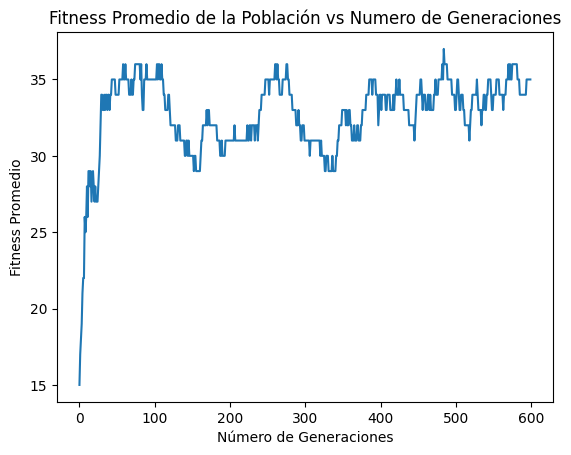

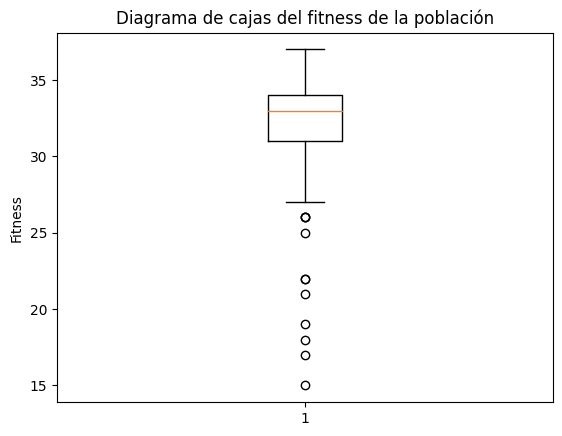

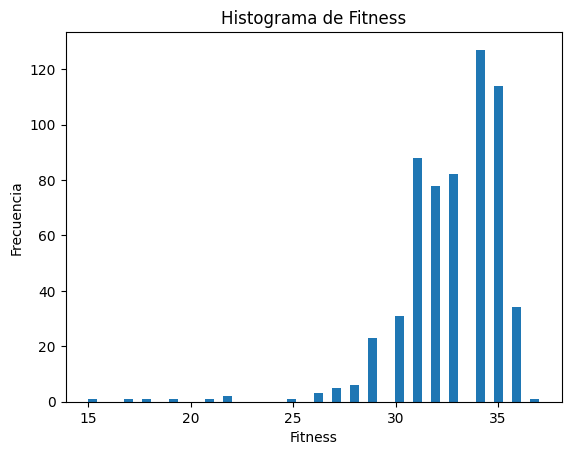

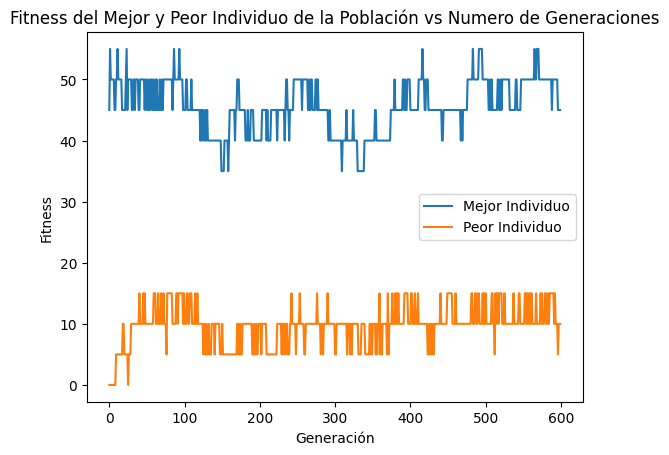

In [11]:
poblacion.visualizacion.fitness_prom_gen()
poblacion.visualizacion.diagrama_cajas()
poblacion.visualizacion.histograma()
poblacion.visualizacion.mejor_peor_fitness()

In [12]:
aux = poblacion.visualizacion.mejor_poblacion.reshape(ngenera,-1)
for i in range(len(aux)):
  print(''.join(aux[i]))

FF+F+F[][F+[+]-]
FF+F+F[]F+F[]+F+
FF--FF-+[][]-F+F
FF+[+FF]F+F[]+FF
FF[--F-FF++][-F]
FF--[]-F[-F]FF-F
FF---FF+F+[][+F]
FFF-[F-+F--][+F]
FFF-[F--F--][+F]
FFF[-F--F--][+F]
FFF[-F--F--]+F[]
FF[-F-F-FF-]+F[]
FF-[-F--F-F]+[F]
FF-[--F-F-F]+[F]
FF[-FFF]-+FF-F[]
FF[-F-F-F+F-F]-F
FF[-F-F+F-F-F+F]
FF-[-F-F++F-F]-F
FFF[-F-F++F-F]-F
FF-[--F+F+F-F]-F
FF-[-F+FF+F-F]-F
FF-[-F-F-F--F]-F
FF-[-F]-F[-FF]F-
FFF[-F]-F[F-F]-F
FF-[-F-FFF][]F--
FFFF-F[-F-][]F-F
FF-[-F]+FF[-F]FF
FF--F-F-F+F-F-FF
FF+F-FF-F-F-F-FF
FF-F-FF-F+F-F--F
FF-F-FF-FFF-FF-F
FF-F-FFF-F-FFF+F
FF-F-F+F-F-FF-FF
FF-F-F-F-F-FF-FF
FF-FF-FF-F-FF-F+
FF-F-F-F-F-FF-FF
FF-F-F+F-F-FF-FF
FF-F-F-F-F-FF-F+
FF-F-F-F-F-FF-F+
FF-F+FFF-F-FF-F+
FF-F+-FF-F-F-FF+
FF-F+-FF-F-F-F+F
FF-F+-FF-F-F-F+F
FF-F+F-F-F+FF-F-
FF-F+F-F-F-FF-F+
FF-F+F-F-F+FF-FF
FF-F+F-FF-F-F-F+
FF-F+-F-FFF-F-F+
FF-F+-F-F+F-F-FF
FF-F-F+F-F+FF-FF
FF--FF+FF-F-F-FF
FF-F--FFF-F-F-FF
FF-F-F-FF-F-F-FF
FF--FF+FF-F-F-FF
FF--FF+FF-F-F-FF
FF-F-F+FF-F-F-FF
FF-F-F+FF-F-F-FF
FF--FF+FF-F-F-FF
FF-F-F+F-FF-F-

In [13]:
aux1 = aux
for i in range(len(aux1)):
  str(aux1[i])
  aux1[i] = ''.join(aux1[i])
  print(aux1[i])

aux2 = []
for i in range(len(aux1)):
  aux2.append(aux1[i][0])


print(aux2)

['FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]'
 'FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]'
 'FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]'
 'FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]'
 'FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]' 'FF+F+F[][F+[+]-]'
 'FF+F+F[][F+[+]-]']
['FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+'
 'FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+'
 'FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+'
 'FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+'
 'FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+' 'FF+F+F[]F+F[]+F+'
 'FF+F+F[]F+F[]+F+']
['FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F'
 'FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F'
 'FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F'
 'FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F'
 'FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F' 'FF--FF-+[][]-F+F'
 'FF--FF-+[][]-F+F']
['FF+[+FF]F+F[]+FF' 'FF+[+FF]F+F[]+FF' 'FF+[+FF]F+F[]+FF'
 'FF+[+FF